In [32]:
import sys,os
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import numpy as np
import sklearn
import string
import re
import nltk
import tensorflow as tf
from collections import Counter
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import pad_sequences,to_categorical
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,precision_score,recall_score,classification_report,roc_curve
from datetime import datetime
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from google.colab import files,drive
from wordcloud import WordCloud, STOPWORDS
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
print(f"Running Panda Version: {pd.__version__}")
print(f"Running TensorFlow Version: {tf.__version__}")
print(f"Running Keras API Version:{keras.__version__}")
print(f"Running Python {sys.version_info[:2][0]}.{sys.version_info[:2][1]}")

Running Panda Version: 2.2.2
Running TensorFlow Version: 2.19.0
Running Keras API Version:3.10.0
Running Python 3.12


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
seed = 0
tf.keras.utils.set_random_seed(seed)

In [34]:
uploaded = files.upload()
dataset = pd.read_csv("Tweets.csv",na_values=['NA'], low_memory=False)

Saving Tweets.csv to Tweets (9).csv


# EDA (Exploratory Data Analysis)

## Descriptive statistics

#### Shape of dataset

In [35]:
shapes = f"Dataset structure: rows: {dataset.shape[0]} - columns: {dataset.shape[1]}"
print(shapes)

Dataset structure: rows: 14640 - columns: 15


#### Radom samples

In [36]:
dataset.sample(4)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
13983,569682010270101504,negative,0.6163,Late Flight,0.6163,American,NaN,zsalim03,NaN,0,@AmericanAir In car gng to DFW. Pulled over 1h...,NaN,2015-02-22 18:15:50 -0800,Texas,Central Time (US & Canada)
14484,569608307184242688,negative,0.7039,Bad Flight,0.3587,American,NaN,sa_craig,NaN,0,"@AmericanAir after all, the plane didn’t land ...",NaN,2015-02-22 13:22:57 -0800,"College Station, TX",Central Time (US & Canada)
6403,567879304593408001,negative,1.0000,Cancelled Flight,1.0000,Southwest,NaN,DanaChristos,NaN,1,@SouthwestAir can't believe how many paying cu...,NaN,2015-02-17 18:52:31 -0800,CT,Eastern Time (US & Canada)
9653,569757651539660801,negative,1.0000,Can't Tell,1.0000,US Airways,NaN,rossj987,NaN,0,@USAirways I can legitimately say that I would...,NaN,2015-02-22 23:16:24 -0800,"Washington, D.C.",Eastern Time (US & Canada)


#### Dataset Features types

In [37]:
dataset.dtypes

,0
tweet_id,int64
airline_sentiment,object
airline_sentiment_confidence,float64
negativereason,object
negativereason_confidence,float64
airline,object
airline_sentiment_gold,object
name,object
negativereason_gold,object
retweet_count,int64


#### Names of columns

In [38]:
", ".join(dataset.columns.tolist())

'tweet_id, airline_sentiment, airline_sentiment_confidence, negativereason, negativereason_confidence, airline, airline_sentiment_gold, name, negativereason_gold, retweet_count, text, tweet_coord, tweet_created, tweet_location, user_timezone'

#### Categorical features

In [39]:
dataset.describe(include='O').T

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


#### Numeric features

In [40]:
dataset.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


#### Target classes

In [41]:
", ".join(dataset.airline_sentiment.unique().tolist())

'neutral, positive, negative'

In [42]:
dataset.airline_sentiment.value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


Imbalance data ( more negatives than positive and neutral)

#### Missing values and duplicates

In [43]:
print('Sum of Missing values accross columns\n',dataset.isnull().sum())
print('-'*40)
print("Sum of missing values",sum(dataset.isnull().sum()))

Sum of Missing values accross columns
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
----------------------------------------
Sum of missing values 61962


In [44]:
print('Sum of duplicated rows :',dataset.duplicated().sum())

Sum of duplicated rows : 36


### Airlines

In [45]:
names_of_airlines = dataset.airline.unique().tolist()
", ".join(names_of_airlines)

'Virgin America, United, Southwest, Delta, US Airways, American'

In [46]:
dataset.airline.value_counts()

,count
airline,
United,3822
US Airways,2913
American,2759
Southwest,2420
Delta,2222
Virgin America,504


#### Tweets

In [47]:
print("Tweets frequencies grouped by sentiments for the airlines")
print('-'*60)
airlines_sentiments_groups = dataset.groupby("airline", group_keys=True)[['airline_sentiment']].value_counts()
airlines_sentiments_groups

Tweets frequencies grouped by sentiments for the airlines
------------------------------------------------------------


airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: count, dtype: int64

In [48]:
print("Time of first tweet in the dataset:",dataset.tweet_created.min())
print('-'*65)
print("Time of last tweet in the dataset:",dataset.tweet_created.max())

Time of first tweet in the dataset: 2015-02-16 23:36:05 -0800
-----------------------------------------------------------------
Time of last tweet in the dataset: 2015-02-24 11:53:37 -0800


In [49]:
dataset[dataset['negativereason'] != 'N/A'].groupby("airline", group_keys=True)[['negativereason']].value_counts()

airline         negativereason             
American        Customer Service Issue         768
                Late Flight                    249
                Cancelled Flight               246
                Can't Tell                     198
                Lost Luggage                   149
                Flight Booking Problems        130
                Bad Flight                      87
                Flight Attendant Complaints     87
                longlines                       34
                Damaged Luggage                 12
Delta           Late Flight                    269
                Customer Service Issue         199
                Can't Tell                     186
                Bad Flight                      64
                Flight Attendant Complaints     60
                Lost Luggage                    57
                Cancelled Flight                51
                Flight Booking Problems         44
                longlines                       14
                Damaged Luggage                 11
Southwest       Customer Service Issue         391
                Cancelled Flight               162
                Can't Tell                     159
                Late Flight                    152
                Bad Flight                      90
                Lost Luggage                    90
                Flight Booking Problems         61
                Flight Attendant Complaints     38
                longlines                       29
                Damaged Luggage                 14
US Airways      Customer Service Issue         811
                Late Flight                    453
                Can't Tell                     246
                Cancelled Flight               189
                Lost Luggage                   154
                Flight Attendant Complaints    123
                Flight Booking Problems        122
                Bad Flight                     104
                longlines                       50
                Damaged Luggage                 11
United          Customer Service Issue         681
                Late Flight                    525
                Can't Tell                     379
                Lost Luggage                   269
                Bad Flight                     216
                Cancelled Flight               181
                Flight Attendant Complaints    168
                Flight Booking Problems        144
                longlines                       48
                Damaged Luggage                 22
Virgin America  Customer Service Issue          60
                Flight Booking Problems         28
                Can't Tell                      22
                Bad Flight                      19
                Cancelled Flight                18
                Late Flight                     17
                Flight Attendant Complaints      5
                Lost Luggage                     5
                Damaged Luggage                  4
                longlines                        3
Name: count, dtype: int64

#### Top tweet authors

In [50]:
top_tweeter = Counter([name for name in dataset['name']])
top_tweeter_df = pd.DataFrame(top_tweeter.most_common(10))
top_tweeter_df.columns = ['top_tweet_authors','count']
print("Top 10 Authors",'-'*15)
top_tweeter_df

Top 10 Authors ---------------


,top_tweet_authors,count
0,JetBlueNews,63
1,kbosspotter,32
2,_mhertz,29
3,otisday,28
4,throthra,27
5,rossj987,23
6,weezerandburnie,23
7,MeeestarCoke,22
8,GREATNESSEOA,22
9,scoobydoo9749,21


#### Two top authors

In [51]:
dataset[dataset['name'] == 'JetBlueNews'][['airline','negativereason','airline_sentiment','retweet_count']].value_counts()

,,,,count
airline,negativereason,airline_sentiment,retweet_count,
Delta,Can't Tell,negative,0,1


In [52]:
dataset[dataset['name'] == 'kbosspotter'][['airline','negativereason','airline_sentiment','retweet_count']].value_counts()

airline  negativereason           airline_sentiment  retweet_count
Delta    Cancelled Flight         negative           0                1
         Customer Service Issue   negative           0                1
         Flight Booking Problems  negative           0                1
         Late Flight              negative           0                1
Name: count, dtype: int64

#### Top reasons for complaints.

In [53]:
top_complain = Counter([reason for reason in dataset[dataset['negativereason'] != 'N/A']['negativereason']])
top_complain_df = pd.DataFrame(top_complain.most_common(10))
top_complain_df.columns = ['top_complain_reason','count']
print("Top 10 complain",'-'*15)
top_complain_df

Top 10 complain ---------------


,top_complain_reason,count
0,NaN,5462
1,Customer Service Issue,2910
2,Late Flight,1665
3,Can't Tell,1190
4,Cancelled Flight,847
5,Lost Luggage,724
6,Bad Flight,580
7,Flight Booking Problems,529
8,Flight Attendant Complaints,481
9,longlines,178


In [54]:
dataset[['text','airline','name','airline_sentiment']].loc[dataset['retweet_count'].max()]

,44
text,@VirginAmerica are flights leaving Dallas for ...
airline,Virgin America
name,papamurat
airline_sentiment,neutral


## Multivariate analysis (Visualization).

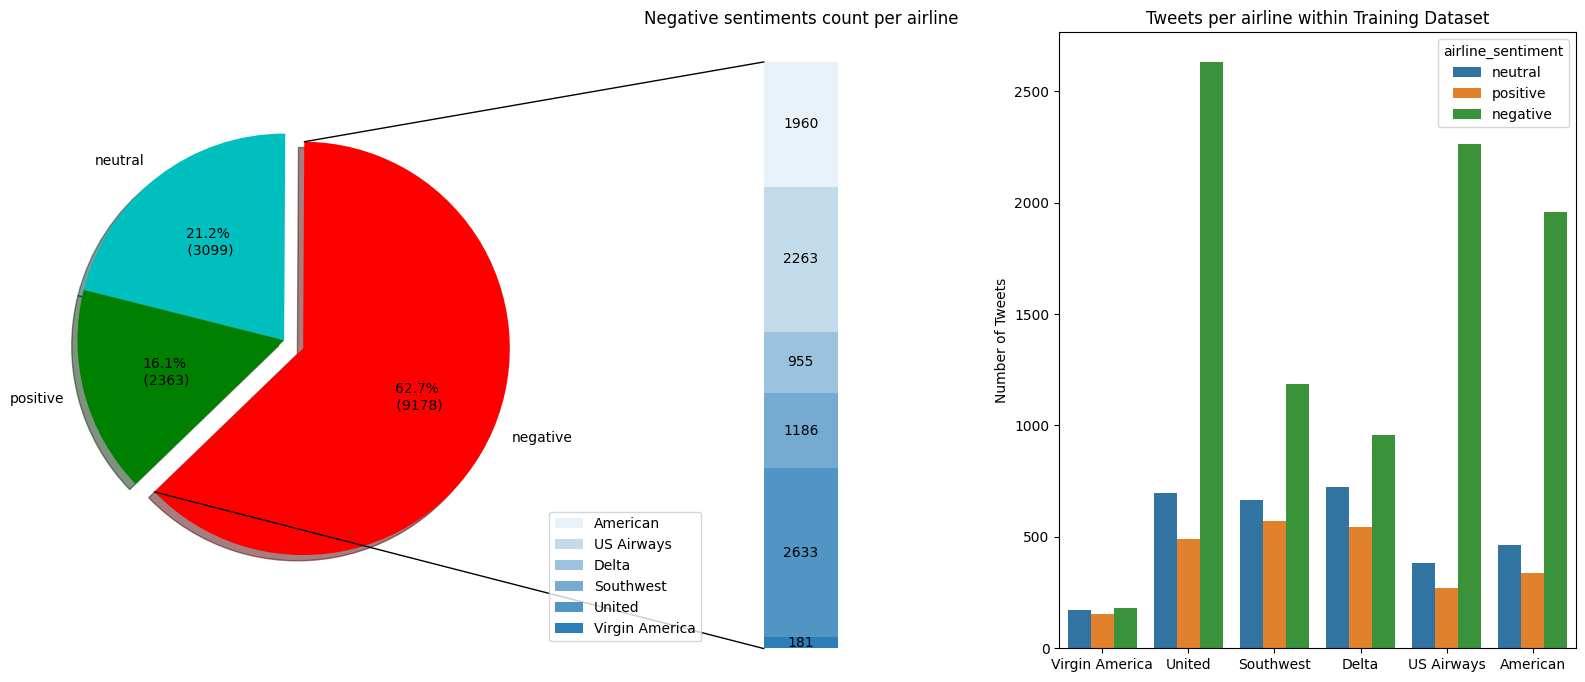

In [55]:
classes,tweet_freq = np.unique(dataset.airline_sentiment,return_counts=True)

def func(pct, allvals)->str:
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n ({absolute:d})"

# make figure and assign axis objects
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 8))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = tweet_freq
labels = classes
explode = [0.1, 0, 0]
colors =['r','c','g']
# rotate so that first wedge is split by the x-axis
angle = -272 * overall_ratios[2]
wedges, *_ = ax1.pie(overall_ratios, autopct=lambda pct: func(pct, overall_ratios),shadow=True,labels=labels, explode=explode,colors=colors,startangle=angle)

# bar chart parameters
negative_sentiment_ratios =[airlines_sentiments_groups[x]['negative'] for x in names_of_airlines]
bottom = 5
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(negative_sentiment_ratios, names_of_airlines)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,alpha=0.1 + 0.17 * j)
    ax2.bar_label(bc, labels=[height], label_type='center')

ax2.legend(loc=3)
ax2.set_title('Negative sentiments count per airline')
ax2.axis('off')
ax2.set_xlim(- 3.5 * width, 3.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(negative_sentiment_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, -bar_height), coordsA=ax2.transData,xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

ax3 = sns.countplot(x="airline", hue="airline_sentiment", data=dataset)
ax3.set_xlabel('')
ax3.set_ylabel('Number of Tweets')
ax3.set_title('Tweets per airline within Training Dataset')


plt.show()
del ax1,ax2,ax3

#### Decompose tweet time  

In [56]:
def decompose_date(date_str)-> pd.Series:
  aux = date_str.replace(' -0800','')
  date_utc = datetime.strptime(aux,"%Y-%m-%d %H:%M:%S")
  return pd.Series([date_utc.weekday(),date_utc.day,date_utc.hour])


dataset[['week_day','day','hour']] = dataset.pop('tweet_created').apply(decompose_date)

#### Daily tweet frequency

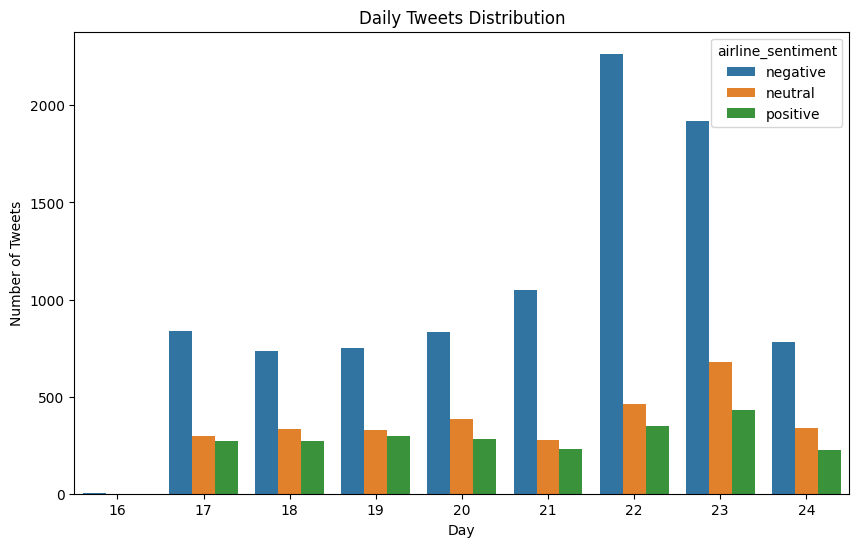

In [57]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.countplot(x="day", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Day')
ax.set_ylabel('Number of Tweets')
ax.set_title('Daily Tweets Distribution')
del ax,fig,axes

#### 24hrs tweet distribution

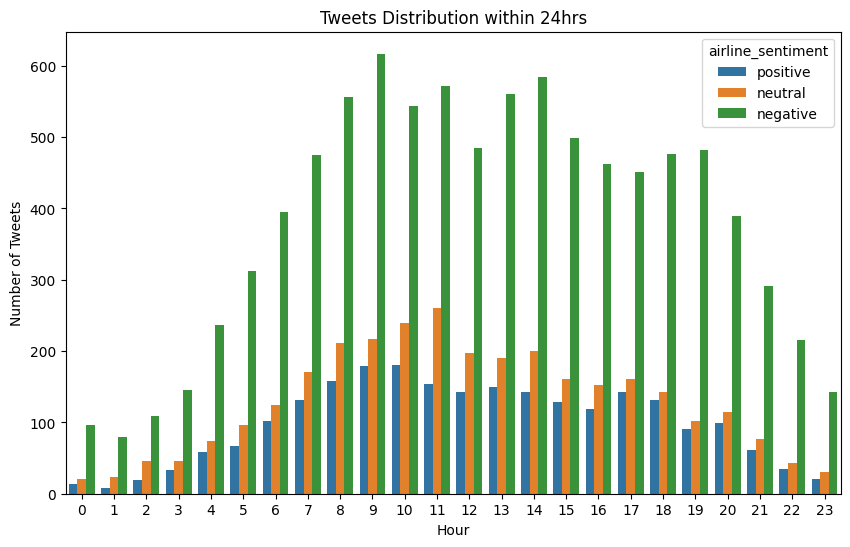

In [58]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.countplot(x="hour", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets Distribution within 24hrs')
del ax,fig,axes

#### Tweets in days of the week

/tmp/ipython-input-645423364.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


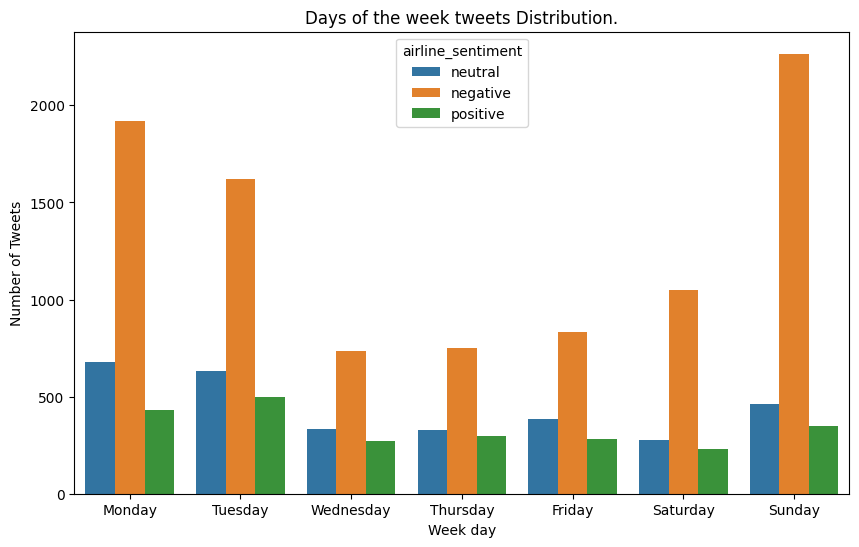

In [59]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.countplot(x="week_day", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Week day')
ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_ylabel('Number of Tweets')
ax.set_title('Days of the week tweets Distribution.')
del ax,fig,axes

#### Word Cloud

In [60]:
positive_sentiment = dataset[dataset.airline_sentiment == "positive"]
positive_text=positive_sentiment['text']
negative_sentiment = dataset[dataset.airline_sentiment == 'negative']
negative_text=negative_sentiment['text']
neutral_sentiment = dataset[dataset.airline_sentiment == 'neutral']
neutral_text=neutral_sentiment['text']
complain_text = top_complain_df['top_complain_reason']
top_authors = top_tweeter_df["top_tweet_authors"]

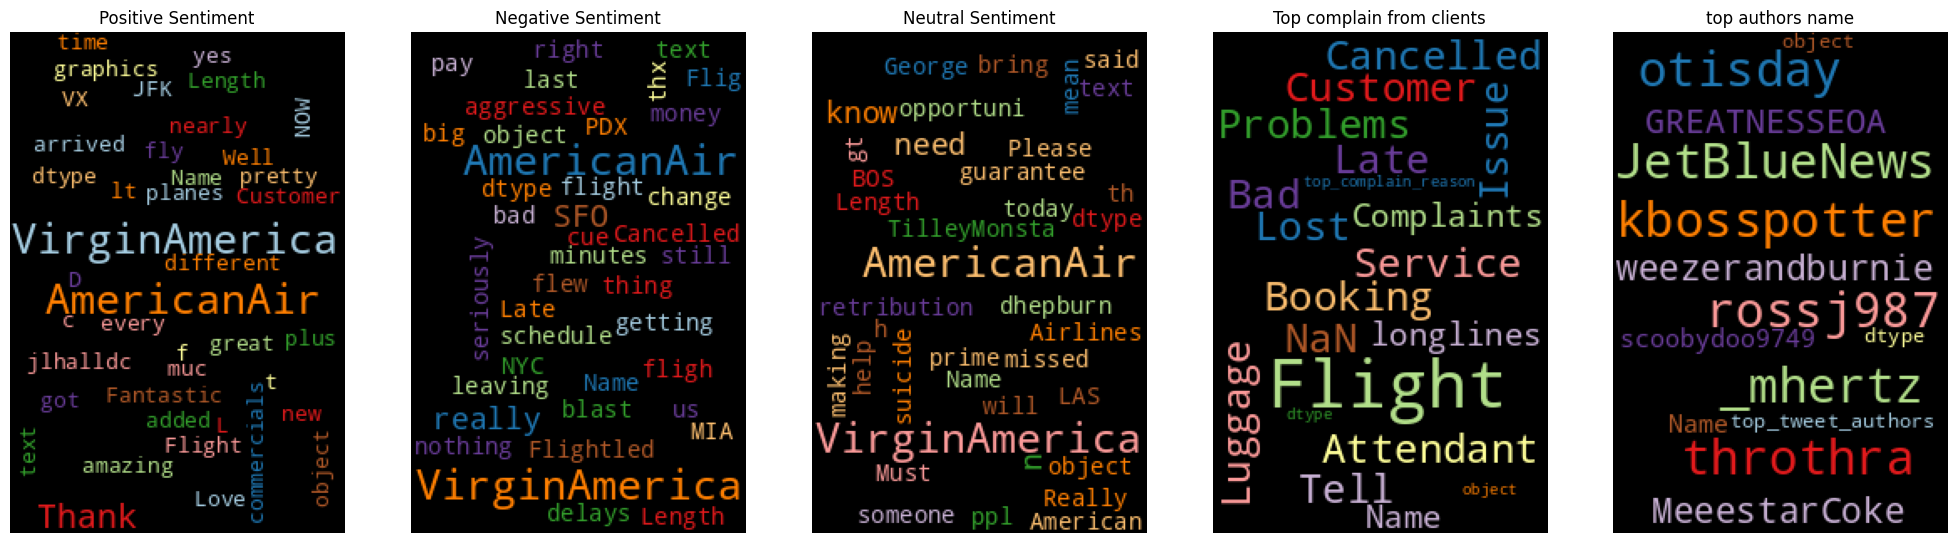

In [61]:
fig, ax = plt.subplots(1, 5, figsize=(25, 8),edgecolor = 'k')
positive_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(positive_text))
negative_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(negative_text))
neutral_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(neutral_text))
complain_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(complain_text))
top_authors_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(top_authors))

ax[0].imshow(positive_tweet)
ax[0].axis('off')
ax[0].set_title('Positive Sentiment')

ax[1].imshow(negative_tweet)
ax[1].axis('off')
ax[1].set_title('Negative Sentiment')

ax[2].imshow(neutral_tweet)
ax[2].axis('off')
ax[2].set_title('Neutral Sentiment')



ax[3].imshow(complain_tweet)
ax[3].axis('off')
ax[3].set_title('Top complain from clients')


ax[4].imshow(top_authors_tweet)
ax[4].axis('off')
ax[4].set_title('top authors name')

plt.show()
del top_tweeter_df,top_complain_df,fig,ax,positive_tweet,negative_tweet,neutral_tweet,complain_tweet,top_authors_tweet

# Data preprocessing

#### Drop rows and columns that are not useful

In [63]:
dataset.drop(neutral_sentiment.index,inplace=True)

In [64]:
dataset.drop(['tweet_id','name','negativereason','negativereason_confidence','airline_sentiment_gold','negativereason_gold','tweet_coord','tweet_location','user_timezone'],axis=1,inplace=True)

In [65]:
dataset.head(3)

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text,week_day,day,hour
1,positive,0.3486,Virgin America,0,@VirginAmerica plus you've added commercials t...,1,24,11
3,negative,1.0000,Virgin America,0,@VirginAmerica it's really aggressive to blast...,1,24,11
4,negative,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...,1,24,11


In [70]:
print('Number of categories: ',len(dataset.airline_sentiment.unique().tolist()))
print('Target categories: ',dataset.airline_sentiment.unique().tolist())
print("Sum of missing values",sum(dataset.isnull().sum()))

Number of categories:  2
Target categories:  ['positive', 'negative']
Sum of missing values 0


##Feature engineering

In [67]:
def remove_url_from_text(tweet:str)->tuple[str,int]:
    url = re.compile(r'https?://\S+|www\.\S+')
    initial = len(tweet)
    text = url.sub(r'',tweet,re.IGNORECASE)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number+=1
    if( final == initial - number):
      return (result,0)
    else:
      return (result,1)

def remove_user_tags(tweet:str)->tuple[str,int]:
    user = re.compile(r'@\S+')
    initial = len(tweet)
    text = user.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number+=1
    if( final == initial - number):
      return [result,0]
    else:
      return [result,1]

def happy_emoji_removal(tweet:str) ->tuple[str,int]:
    happy = re.compile(r"([xX;:]-?[dDpP)])")
    initial = len(tweet)
    text = happy.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

def sad_emoji_removal(tweet:str) -> tuple[str,int]:
    sad = re.compile(r"[:;](['\"]?[-~]?[/(\|C<>{}\[]+)")
    initial = len(tweet)
    text = sad.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

def clean_and_create_feature(tweet:str)-> pd.Series:
  (text,user_flag) = remove_user_tags(tweet)
  (text,url_flag) = remove_url_from_text(text)
  (text,happy_flag) = happy_emoji_removal(text)
  (text,sad_flag) = sad_emoji_removal(text)
  return pd.Series([text,user_flag,url_flag,happy_flag,sad_flag])

dataset[['text','user_flag','url_flag','happy_flag','sad_flag']] = dataset.text.apply(clean_and_create_feature)

In [68]:
dataset.head(3)

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text,week_day,day,hour,user_flag,url_flag,happy_flag,sad_flag
1,positive,0.3486,Virgin America,0,plus you've added commercials to the eerience...,1,24,11,1,0,1,0
3,negative,1.0000,Virgin America,0,"it's really aggressive to blast obnoxious ""en...",1,24,11,1,0,0,0
4,negative,1.0000,Virgin America,0,and it's a really big bad thing about it,1,24,11,1,0,0,0


#### Stop word and punctuation removal and stemming

In [69]:
def stop_word_and_stemming(tweet:str)->str:
    tknzr = TweetTokenizer(preserve_case=False,strip_handles=True, reduce_len=True)
    myStemmer = PorterStemmer()
    tweet = tknzr.tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    new_list = [myStemmer.stem(word) for word in tweet if word not in stop_words]
    tweet = ' '.join(new_list)
    return tweet

def remove_punctuations(text:str)->str:
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
dataset['text'] = dataset['text'].apply(stop_word_and_stemming)
dataset['text'] = dataset['text'].apply(remove_punctuations)

#### Target Encoding, $y_{i}$ can take values between  ${0}$ to  ${N-1}$

In [72]:
target_dict = {'positive':1,'negative': 0}
print(target_dict)
dataset['target'] = dataset['airline_sentiment'].map(target_dict)
del target_dict

{'positive': 1, 'negative': 0}


In [73]:
dataset.head(3)

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text,week_day,day,hour,user_flag,url_flag,happy_flag,sad_flag,target
1,positive,0.3486,Virgin America,0,plu ad commerci eerienc tacki,1,24,11,1,0,1,0,1
3,negative,1.0000,Virgin America,0,realli aggress blast obnoxi entertain guest ...,1,24,11,1,0,0,0,0
4,negative,1.0000,Virgin America,0,realli big bad thing,1,24,11,1,0,0,0,0


#### Split Dataset